1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров. Подобрать оптимальные значения этих гиперпараметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [59]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 10

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [60]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

### расчет параметров зависимости ошибки на обучающей и тестовой выборках от числа деревьев.

In [58]:
train_err_trees = []
test_err_trees = []
for i in range(n_trees):
    trees, train_errors, test_errors = gb_fit( i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err_trees.append(mean_squared_error(y_train, train_prediction))
    test_err_trees.append(mean_squared_error(y_test, test_prediction))

### Графики зависимости ошибки на обучающей и тестовой выборках от числа деревьев.

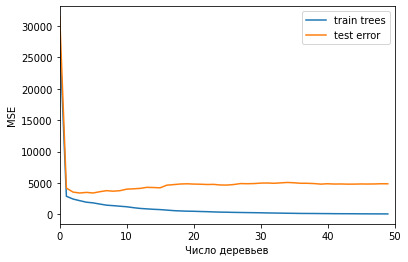

In [36]:
import matplotlib.pyplot as plt

plt.xlabel('Число деревьев')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), train_err_trees, label='train trees')
plt.plot(list(range(n_trees)), test_err_trees, label='test error')
plt.legend(loc='upper right')
plt.show()

### Графики зависимости ошибки на обучающей и тестовой выборках от максимальной глубины деревьев.

In [61]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 20

# Шаг
eta = 0.1

train_err_depth = []
test_err_depth = []
for i in range(max_depth):
    trees, train_errors, test_errors = gb_fit( i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err_depth.append(mean_squared_error(y_train, train_prediction))
    test_err_depth.append(mean_squared_error(y_test, test_prediction))

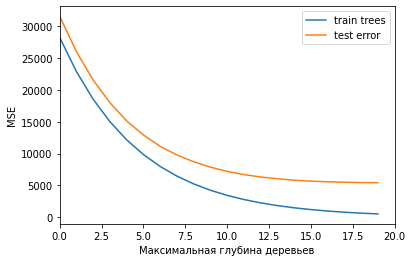

In [62]:
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('MSE')
plt.xlim(0, max_depth)
plt.plot(list(range(max_depth)), train_err_depth, label='train trees')
plt.plot(list(range(max_depth)), test_err_depth, label='test error')
plt.legend(loc='upper right')
plt.show()

In [54]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 20

# Шаг
eta = 0.1

train_err_depth = []
test_err_depth = []
for i in range(max_depth):
    trees, train_errors, test_errors = gb_fit( i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err_depth.append(mean_squared_error(y_train, train_prediction))
    test_err_depth.append(mean_squared_error(y_test, test_prediction))

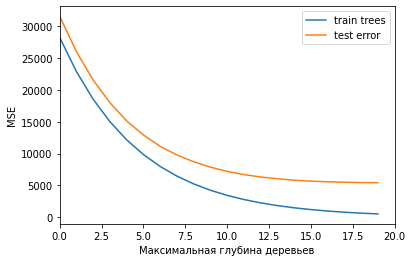

In [55]:
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('MSE')
plt.xlim(0, max_depth)
plt.plot(list(range(max_depth)), train_err_depth, label='train trees')
plt.plot(list(range(max_depth)), test_err_depth, label='test error')
plt.legend(loc='upper right')
plt.show()

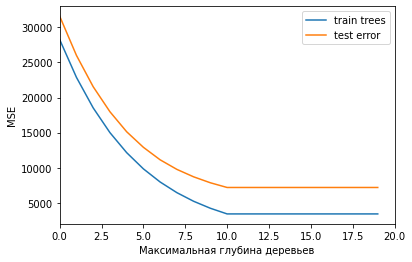

In [64]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 20

# Шаг
eta = 0.1

train_err_depth = []
test_err_depth = []
for i in range(max_depth):
    trees, train_errors, test_errors = gb_fit( i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err_depth.append(mean_squared_error(y_train, train_prediction))
    test_err_depth.append(mean_squared_error(y_test, test_prediction))

plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('MSE')
plt.xlim(0, max_depth)
plt.plot(list(range(max_depth)), train_err_depth, label='train trees')
plt.plot(list(range(max_depth)), test_err_depth, label='test error')
plt.legend(loc='upper right')
plt.show()

### Ответ: оптимальные показатели 10 деревьев,макисмальной глубины 10, eta = 0.1

In [79]:
n_trees = 10
eta = 0.1
max_depth = 10

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.1 на тренировочной выборке: 3516.3497201619302
Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.1 на тестовой выборке: 6728.978076016636
